<a href="https://colab.research.google.com/github/Mubarok982/forecasting/blob/main/Multivariate_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import pandas as pd
import tensorflow as tf

## **Load Dataset**

In [8]:
data = pd.read_csv('https://drive.google.com/uc?id=1AZRfFoyekqSYpri5183RmJjciRGz_ood', sep=',',
                     infer_datetime_format=True, index_col='datetime', header=0)
data

/tmp/ipython-input-8-2098438377.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv('https://drive.google.com/uc?id=1AZRfFoyekqSYpri5183RmJjciRGz_ood', sep=',',


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
...,...,...,...,...,...,...,...
2007-02-14 17:19:00,0.636,0.140,241.16,2.6,0.0,0.0,0.0
2007-02-14 17:20:00,0.552,0.000,240.46,2.2,0.0,0.0,0.0
2007-02-14 17:21:00,0.538,0.000,239.74,2.2,0.0,0.0,0.0


# **Data Prepocessing**

In [9]:
def normalize_series(data, min, max):
  data = data - min
  data = data / max
  return data

n_features = data.shape[1]
data = data.values
data = normalize_series(data, data.min(axis=0), data.max(axis=0))

## **Hitung Jumlah fitur**

In [10]:
N_FEATURES = data.shape[1]
print(type(data))
print(data.shape)

<class 'numpy.ndarray'>
(86400, 7)


## **Split Data**

In [11]:
split_time = int(len(data) * 0.5)
x_train = data[:split_time]
x_valid = data[split_time:]

In [12]:
def windowed_dataset(series, batch_size, n_past=24, n_future=24, shift=1):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(size=n_past + n_future, shift=shift, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(n_past + n_future))
  ds = ds.map(lambda w: (w[:n_past], w[n_past:]))
  return ds.batch(batch_size).prefetch(1)

In [13]:
BATCH_SIZE = 32
N_PAST = 24
N_FUTURE = 24
SHIFT = 1
train_set = windowed_dataset(series=x_train, batch_size=BATCH_SIZE,
                                 n_past=N_PAST, n_future=N_FUTURE,
                                 shift=SHIFT)
valid_set = windowed_dataset(series=x_valid, batch_size=BATCH_SIZE,
                                 n_past=N_PAST, n_future=N_FUTURE,
                                 shift=SHIFT)

In [14]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(64, input_shape=(N_PAST, N_FEATURES)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(N_FEATURES)
    ])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if (logs.get('mae') < 0.055 and logs.get('val_mae') < 0.055):
                self.model.stop_training = True

callbacks = myCallback()

In [16]:
# Kode untuk melakukan menyusun struktur sesuai dengan machine learning
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss='mae',
                  optimizer= optimizer,
                  metrics=["mae"])

In [17]:
model.fit(train_set,
          validation_data=(valid_set),
          epochs=100,
          callbacks=callbacks,
          verbose=1
    )

Epoch 1/100
   1349/Unknown 13s 8ms/step - loss: 0.0846 - mae: 0.0846

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1349/1349 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - loss: 0.0846 - mae: 0.0846 - val_loss: 0.0594 - val_mae: 0.0594
Epoch 2/100
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - loss: 0.0603 - mae: 0.0603 - val_loss: 0.0604 - val_mae: 0.0604
Epoch 3/100
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - loss: 0.0595 - mae: 0.0595 - val_loss: 0.0571 - val_mae: 0.0571
Epoch 4/100
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - loss: 0.0584 - mae: 0.0584 - val_loss: 0.0581 - val_mae: 0.0581
Epoch 5/100
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - loss: 0.0585 - mae: 0.0585 - val_loss: 0.0582 - val_mae: 0.0582
Epoch 6/100
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - loss: 0.0581 - mae: 0.0581 - val_loss: 0.0584 - val_mae: 0.0584
Epoch 7/100
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 36s 12ms/step - loss: 0.0578 - mae: 0.0578 - val_loss: 0.0575 - val_mae: 0.0575
Epoch 8/100
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - loss: 0.0575 - mae: 0.0575 - val_loss: 0.0580 - val_mae: 0.0580
Epoch 9/100
1349/1349 ━━━━━━

## **prediksi**

In [19]:
train_pred = model.predict(train_set)
train_pred[0][0]
# Output

1349/1349 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step


array([ 0.38703358,  0.24915108,  0.02822128,  0.3697398 , -0.00613915,
       -0.00139758,  0.8359559 ], dtype=float32)

1349/1349 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


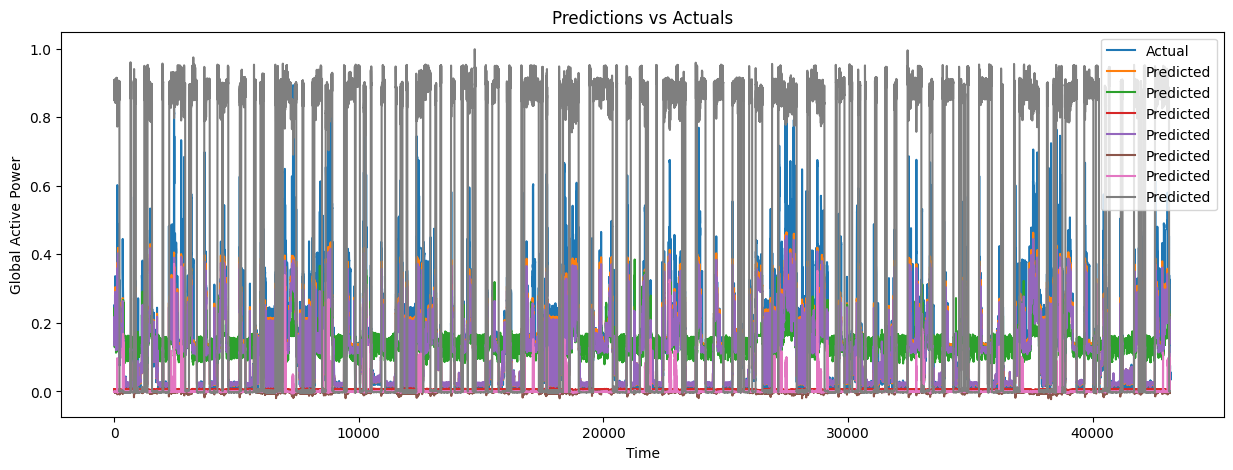

In [21]:
import matplotlib.pyplot as plt
# Make predictions on the validation set
y_pred = model.predict(valid_set)

# Denormalize the predictions and the validation set
y_pred = y_pred * data.max(axis=0) + data.min(axis=0)
x_valid_denorm = x_valid * data.max(axis=0) + data.min(axis=0)

# Plot the predictions vs the actual values
plt.figure(figsize=(15, 5))
plt.plot(x_valid_denorm[:, 0], label='Actual')
plt.plot(y_pred[:, 0], label='Predicted')
plt.title('Predictions vs Actuals')
plt.xlabel('Time')
plt.ylabel('Global Active Power')
plt.legend()
plt.show()